In [2]:
#Segmentation of Nuclei

In [4]:
import mahotas as mh
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

In [5]:
%matplotlib inline

In [7]:
#This will import the 3-channel 24z stack tiff
im = io.imread('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_2_Box1.tif')
print im.shape

(24L, 512L, 512L, 3L)


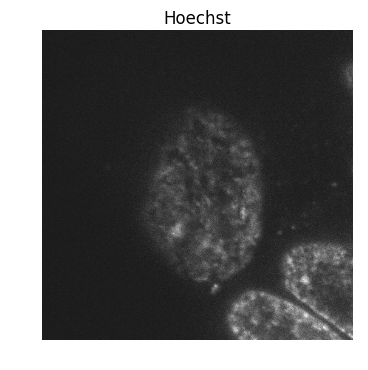

In [30]:
#Channel=0 is Hoechst
plt.imshow(im[0,:,:,0],cmap='gray')
plt.axis('off')
plt.title('Hoechst')

153


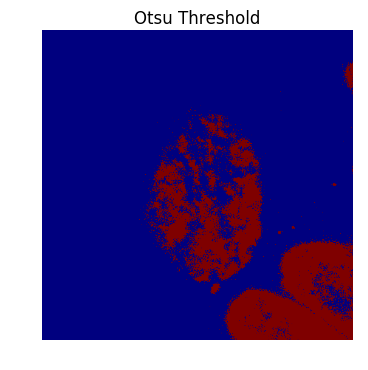

In [26]:
T_otsu = mh.otsu(im[0,:,:,0])
print(T_otsu)
plt.imshow(im[0,:,:,0] > T_otsu)
plt.axis('off')
plt.title('Otsu Threshold')

127.500957489


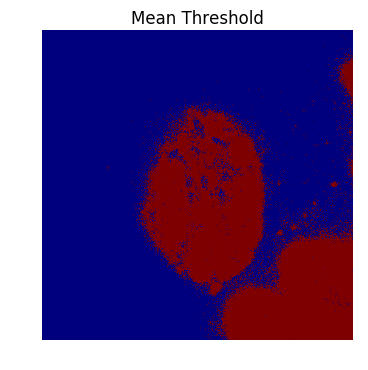

In [25]:
T_mean = im[0,:,:,0].mean()
print(T_mean)
plt.imshow(im[0,:,:,0] > T_mean)
plt.axis('off')
plt.title('Mean Threshold')

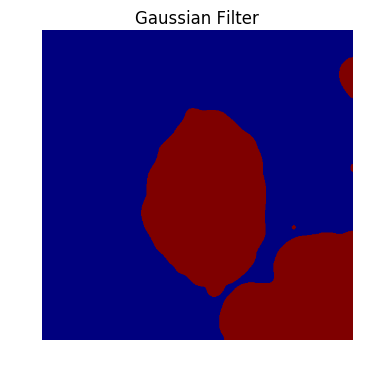

In [27]:
imf = mh.gaussian_filter(im[0,:,:,0], 6.)
T_mean = imf.mean()
bin_image = imf > T_mean
plt.imshow(bin_image)
plt.axis('off')
plt.title('Gaussian Filter')

5


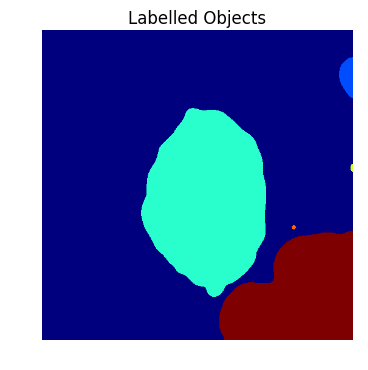

In [29]:
labeled, nr_objects = mh.label(bin_image)
print(nr_objects)

plt.imshow(labeled)
plt.jet()
plt.axis('off')
plt.title('Labelled Objects')

https://github.com/luispedro/python-image-tutorial/blob/master/Segmenting%20cell%20images%20(fluorescent%20microscopy).ipynb

**Also Try**

http://morphogenie.fr/segmenting-nuclei.html

**Separating touching cells**

We now got the cells nicely separated from the background, but we have also merged several cells together.

The general strategy we can use to separate the cells is the following:

Smooth the image with a Gaussian filter (we need to specify the  $\sigma$ parameter)
Find regional maxima on this smoothed image to identify each cell
Use watershed on the distance transformed image to separate cells.
We are going to use an interactive mode function to find out the best value for $\sigma$:

In [ ]:
@interact(sigma=(1.,16.))
def check_sigma(sigma):
    dnaf = mh.gaussian_filter(dna.astype(float), sigma)
    maxima = mh.regmax(mh.stretch(dnaf))
    maxima = mh.dilate(maxima, np.ones((5,5)))
    plt.imshow(mh.as_rgb(np.maximum(255*maxima, dnaf), dnaf, dna > T_mean))
It seems $\sigma = 12$ is a pretty good guess:

In [ ]:
sigma = 12.0
dnaf = mh.gaussian_filter(dna.astype(float), sigma)
maxima = mh.regmax(mh.stretch(dnaf))
maxima,_= mh.label(maxima)
plt.imshow(maxima)

Now, we compute the distance transform. Again, this is a single call, mh.distance:

In [ ]:
dist = mh.distance(bin_image)
plt.imshow(dist)

Because of the way that the watershed function is defined in mahotas, we need to invert the distance transform. 
Also, for technical reasons, we convert to uint8.
Finally, we can call mh.cwatershed with the dist image and the maxima as seeds.

In [ ]:


    




In [ ]:
dist = 255 - mh.stretch(dist)
watershed = mh.cwatershed(dist, maxima)
plt.imshow(watershed)
We now take away the background to make things nicer:

In [ ]:
watershed *= bin_image
plt.imshow(watershed)
Cleaning up regions
Almost there.

Let's first remove cells touching the border (the module mh.labeled has several functions to deal with labeled images):

In [ ]:
watershed = mh.labeled.remove_bordering(watershed)
plt.imshow(watershed)
Let us also remove things that are too small to be a cell. Again, we use an interactive display to choose the parameters:

In [ ]:
sizes = mh.labeled.labeled_size(watershed)

# The conversion below is not necessary in newer versions of mahotas:
watershed = watershed.astype(np.intc)

@interact(min_size=(100,4000,20))
def do_plot(min_size):
    filtered = mh.labeled.remove_regions_where(watershed, sizes < min_size)
    print("filtering {}...".format(min_size))
    plt.imshow(filtered)
2000 seems like it works.

So, we remove these regions and relabel.

Relabeling is necessary because the remove_regions_where call only sets the removed regions to zero, relabeling is necessary to make the result be in the range 0 .. N. Relabel also returns the number of objects that are left.

In [ ]:
min_size = 2000
filtered = mh.labeled.remove_regions_where(watershed, sizes < min_size)

labeled,nr_objects = mh.labeled.relabel(filtered)
print("Number of cells: {}".format(nr_objects))